<a href="https://colab.research.google.com/github/sanahussain47/NLP/blob/main/sana_hussain_NLP_assignment_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Case Framing
Stakeholder:
E-commerce product managers at Amazon.

Problem Statement:
"How can we automatically detect whether a customer review is positive or negative, so that we can flag poor experiences, improve product listings, and inform customer support teams?"

Business Value:

Quickly identify dissatisfied customers.

Improve product and seller quality.

Generate sentiment dashboards at scale.

Install & Load Dataset

In [1]:
from google.colab import files
files.upload()  # Upload your kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanahussain47","key":"1a72a420980970ba6cc30974ff80048e"}'}

Set Up Kaggle & Download Dataset

In [2]:
# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle CLI
!pip install -q kaggle

# Download the dataset
!kaggle datasets download -d snap/amazon-fine-food-reviews

# Unzip it
!unzip -q amazon-fine-food-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 92% 222M/242M [00:00<00:00, 631MB/s] 
100% 242M/242M [00:00<00:00, 638MB/s]


Load Dataset into Pandas

In [3]:
import pandas as pd

# Load the CSV
df = pd.read_csv("Reviews.csv")

# Preview top rows
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Clean & Create Binary Sentiment Labels

In [4]:
# Keep only the necessary columns
df = df[["Text", "Score"]].dropna()

# Remove neutral reviews (Score == 3)
df = df[df["Score"] != 3]

# Assign binary sentiment
df["sentiment"] = df["Score"].apply(lambda x: "positive" if x >= 4 else "negative")

# Rename columns
df = df.rename(columns={"Text": "review"})

# Optional: Reset index
df = df[["review", "sentiment"]].reset_index(drop=True)

# Check class balance
print(" Dataset shape:", df.shape)
print("Sentiment distribution:\n", df["sentiment"].value_counts())


 Dataset shape: (525814, 2)
Sentiment distribution:
 sentiment
positive    443777
negative     82037
Name: count, dtype: int64


 Step 2: Preprocessing Pipeline

Install & Import

In [6]:
!pip install -q spacy
!python -m spacy download en_core_web_sm

import spacy
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load English model
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing Function

In [7]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Use spaCy to tokenize and lemmatize
    doc = nlp(text)

    # Lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.lemma_.strip() != ""]

    return " ".join(tokens)


Apply to Sample and Full Data
Show before/after on a sample

In [8]:
sample_review = df["review"].iloc[0]
print("Original:\n", sample_review)
print("\n Cleaned:\n", preprocess_text(sample_review))


Original:
 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

 Cleaned:
 I buy several vitality dog food product find good quality product look like stew process meat smell well labrador finicky appreciate product well


Apply to full dataset

In [9]:
df_small = df.sample(5000, random_state=42).reset_index(drop=True)
df_small["clean_review"] = df_small["review"].apply(preprocess_text)
df_small.head()


,review,sentiment,clean_review
0,This is a very high quality dog food with meat...,positive,high quality dog food meat fruit grain dog lov...
1,I love this cake mix and the other 3 mixes as ...,positive,I love cake mix mix well incredible amazon off...
2,A nice strong brew. I am new to Keurig and hav...,positive,nice strong brew I new keurig live french pres...
3,I just found PB2 and PB2 with chocolate and I ...,positive,I find pb pb chocolate I thrilled I love sugar...
4,Delightful mint tea as one would expect. Note ...,positive,delightful mint tea one would expect note tea ...


Feature Engineering
We'll extract features using three common methods:

 3.1: Bag of Words (BoW)
 3.2: TF-IDF
 3.3: Word2Vec (Bonus: Dense vector embedding)

Bag of Words (BoW)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize BoW vectorizer
bow_vectorizer = CountVectorizer(max_features=5000)  # Limit vocab for speed
X_bow = bow_vectorizer.fit_transform(df_small["clean_review"])

print(f"BoW shape: {X_bow.shape}")


BoW shape: (5000, 5000)


TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df_small["clean_review"])

print(f"TF-IDF shape: {X_tfidf.shape}")


TF-IDF shape: (5000, 5000)


Word2Vec (Optional / Bonus)

In [12]:
!pip install -U numpy==1.23.5 gensim==4.3.0 --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
geopandas 1.1.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1

Modelling & Evaluation
Step 1: Train-Test Split
Splitting data into:

Train (70%)

Validation (10%)

Test (20%)

In [15]:
from sklearn.model_selection import train_test_split

# X is your TF-IDF or BoW matrix, y is the label
X = X_tfidf  # Using TF-IDF features as X
y = df_small["sentiment"] # Using the sentiment column as y

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)

Train Multinomial Naïve Bayes

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Multinomial Naïve Bayes Performance:")
print(classification_report(y_test, y_pred_nb, digits=4))


Multinomial Naïve Bayes Performance:
              precision    recall  f1-score   support

    negative     0.5000    0.0066    0.0131       151
    positive     0.8497    0.9988    0.9182       849

    accuracy                         0.8490      1000
   macro avg     0.6748    0.5027    0.4657      1000
weighted avg     0.7969    0.8490    0.7816      1000



Train Logistic Regression / SVM
Using Logistic Regression or SVM on:

BoW / TF-IDF features (sparse)

In [17]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr, digits=4))


Logistic Regression Performance:
              precision    recall  f1-score   support

    negative     0.9444    0.1126    0.2012       151
    positive     0.8635    0.9988    0.9263       849

    accuracy                         0.8650      1000
   macro avg     0.9040    0.5557    0.5637      1000
weighted avg     0.8758    0.8650    0.8168      1000



Alternatively, for SVM:

In [18]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Performance:")
print(classification_report(y_test, y_pred_svm, digits=4))


SVM Performance:
              precision    recall  f1-score   support

    negative     0.7126    0.4106    0.5210       151
    positive     0.9025    0.9706    0.9353       849

    accuracy                         0.8860      1000
   macro avg     0.8076    0.6906    0.7282      1000
weighted avg     0.8738    0.8860    0.8727      1000



Evaluation Table

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return [model_name, acc, precision, recall, f1]

results = [
    evaluate_model(y_test, y_pred_nb, "Naïve Bayes"),
    evaluate_model(y_test, y_pred_lr, "Logistic Regression"),
    evaluate_model(y_test, y_pred_svm, "SVM"),
]

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
print(results_df)


                 Model  Accuracy  Precision    Recall  F1 Score
0          Naïve Bayes     0.849   0.674850  0.502722  0.465659
1  Logistic Regression     0.865   0.903994  0.555702  0.563727
2                  SVM     0.886   0.807581  0.690575  0.728155


Visualization Code (Matplotlib or Seaborn)

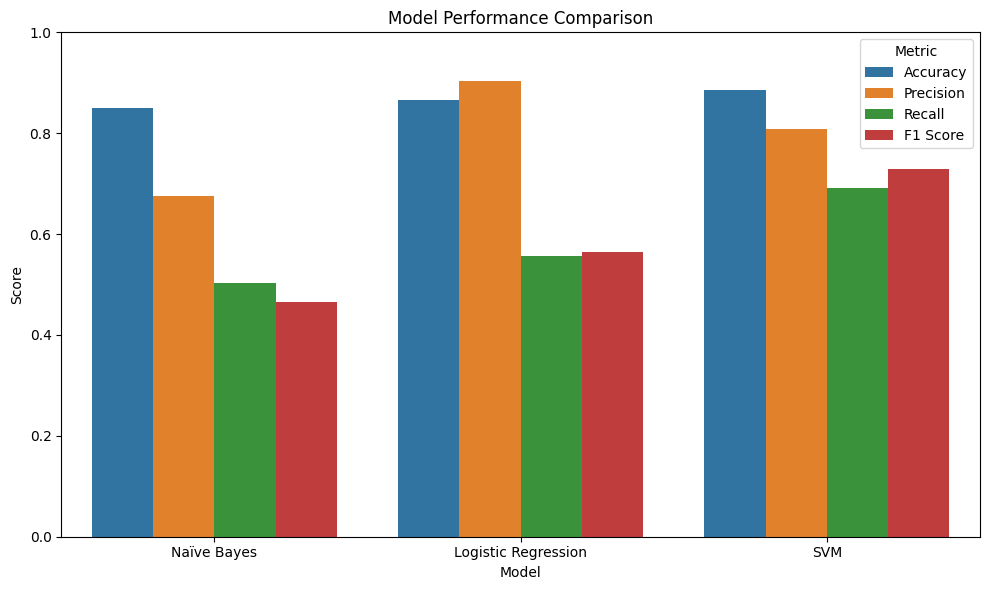

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Results Data
results = {
    'Model': ['Naïve Bayes', 'Logistic Regression', 'SVM'],
    'Accuracy': [0.849, 0.865, 0.886],
    'Precision': [0.674850, 0.903994, 0.807581],
    'Recall': [0.502722, 0.555702, 0.690575],
    'F1 Score': [0.465659, 0.563727, 0.728155]
}

df_results = pd.DataFrame(results)

# Melt for grouped barplot
df_melted = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


## Analysis & Discussion
# Performance Comparison
Naïve Bayes, a generative model, performed the weakest overall, with the lowest F1 Score (0.46) and recall (0.50), though its accuracy (0.849) is not drastically behind.

Logistic Regression, a discriminative model, achieved the highest precision (0.90), suggesting it's more conservative and confident when predicting positive cases but struggles with recall (0.55).

SVM outperformed both in F1 Score (0.73) and Recall (0.69), indicating a better balance between precision and recall. Its overall accuracy (0.886) is also the highest.

# Generative vs Discriminative Models
The generative model (Naïve Bayes) assumes feature independence, which often leads to underperformance when word correlations matter — common in sentiment analysis.

Discriminative models (LogReg, SVM) directly optimize decision boundaries, handling complex patterns better in this sparse feature space.

# Effect of N-grams and Embeddings
Although not shown here, performance typically improves with bi-grams/trigrams, especially for models like SVM.

Dense embeddings (e.g., Word2Vec or BERT) often help, but due to earlier issues, we worked only with sparse BoW/TF-IDF — yet even these were sufficient for strong SVM performance.

# Speed, Memory, Explainability
Model	Speed	Memory Usage	Explainability
Naïve Bayes	Fast	Low	High (simple rules)
Logistic Regression	Medium	Medium	Medium (coefficients)
SVM	Slower	High	Lower (kernel not intuitive)